In [1]:
# ==========================================
# CELL 1: ENTERPRISE ENVIRONMENT SETUP (VERSION ALIGNED)
# ==========================================
# 1. Force Compatible Version Trio
!pip install -Uq protobuf==3.20.3
!pip install -Uq transformers==4.48.0 accelerate==0.27.0 peft==0.8.2 sentencepiece emoji datasets scikit-learn seaborn

import os
import re
import html
import json
import emoji
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    confusion_matrix, 
    classification_report,
    matthews_corrcoef
)
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import Dataset

# --- PLATINUM CONFIGURATION ---
SAMPLE_SIZE = 1000000        # 1 MILLION Samples
MODEL_CHECKPOINT = "microsoft/deberta-v3-base" 
RANDOM_SEED = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(RANDOM_SEED)
print("✅ System Initialized. Ready for 1M Run.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, bu

2025-11-25 10:56:41.425187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764068201.610994      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764068201.685553      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ System Initialized. Ready for 1M Run.


In [2]:
# ==========================================
# CELL 2: LOADING 1 MILLION SAMPLES
# ==========================================
print(f">> Loading Data (Target: {SAMPLE_SIZE:,} rows)...")

# Auto-detect Input File
INPUT_FILE = ""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if 'training' in filename and 'csv' in filename:
            INPUT_FILE = os.path.join(dirname, filename)
            break

if not INPUT_FILE:
    raise FileNotFoundError("❌ ERROR: Add 'sentiment140' dataset to Kaggle!")

try:
    # Load with Latin-1 (Standard for Sentiment140)
    df_full = pd.read_csv(
        INPUT_FILE, 
        encoding='latin-1', 
        header=None, 
        names=['sentiment', 'id', 'date', 'flag', 'user', 'text']
    )
except Exception as e:
    print(f"Error: {e}")
    exit(1)

# Rigorous Stratified Sampling (500k Neg / 500k Pos)
neg_df = df_full[df_full['sentiment'] == 0]
pos_df = df_full[df_full['sentiment'] == 4]

half_sample = SAMPLE_SIZE // 2
neg_sample = neg_df.sample(n=half_sample, random_state=RANDOM_SEED)
pos_sample = pos_df.sample(n=half_sample, random_state=RANDOM_SEED)

df = pd.concat([neg_sample, pos_sample])
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# Map Labels: 0->0 (Negative), 4->1 (Positive)
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})

# Memory Optimization: Clear the huge raw dataframe immediately
del df_full, neg_df, pos_df, neg_sample, pos_sample
import gc
gc.collect()

print(f"✅ Data Loaded. Shape: {df.shape}")
print(df['sentiment'].value_counts())

>> Loading Data (Target: 1,000,000 rows)...
✅ Data Loaded. Shape: (1000000, 6)
sentiment
1    500000
0    500000
Name: count, dtype: int64


In [3]:
# ==========================================
# CELL 3: PREPROCESSING & SPLITTING
# ==========================================
print(">> Applying Advanced Sanitization (Demojization + Cleaning)...")

URL_PATTERN = re.compile(r'http\S+|www\S+|https\S+')
USER_PATTERN = re.compile(r'@\w+')

def clean_text(text):
    text = str(text)
    text = html.unescape(text)       # Fix HTML (&amp; -> &)
    text = emoji.demojize(text)      # Value-Add: Preserve emotion semantics
    text = URL_PATTERN.sub('', text) # Remove URLs
    text = USER_PATTERN.sub('', text)# Remove Mentions
    return text.strip()

# Apply cleaning (This takes ~1-2 mins for 1M rows)
df['text'] = df['text'].apply(clean_text)

# Reserve held-out Test Set (Last 10,000 samples for high-confidence stats)
test_size = 10000
test_df = df.tail(test_size).copy()
train_val_df = df.iloc[:-test_size]

# 95/5 Train/Validation Split (Given 1M rows, 5% val is plenty)
X_train, X_val, y_train, y_val = train_test_split(
    train_val_df['text'], 
    train_val_df['sentiment'], 
    test_size=0.05, 
    stratify=train_val_df['sentiment'], 
    random_state=RANDOM_SEED
)

print(f"✅ Preprocessing Done.")
print(f"   Train Corpus: {len(X_train):,}")
print(f"   Val Corpus:   {len(X_val):,}")
print(f"   Test Corpus:  {len(test_df):,}")

>> Applying Advanced Sanitization (Demojization + Cleaning)...
✅ Preprocessing Done.
   Train Corpus: 940,500
   Val Corpus:   49,500
   Test Corpus:  10,000


In [ ]:
# ==========================================
# CELL 4: ESTABLISHING SCIENTIFIC BASELINE
# ==========================================
print(">> Training TF-IDF + Logistic Regression Baseline (1M Rows)...")

baseline_pipeline = make_pipeline(
    TfidfVectorizer(max_features=25000, ngram_range=(1,2)),
    LogisticRegression(max_iter=1000, solver='liblinear')
)

baseline_pipeline.fit(X_train, y_train)
base_preds = baseline_pipeline.predict(test_df['text'])

base_acc = accuracy_score(test_df['sentiment'], base_preds)
base_mcc = matthews_corrcoef(test_df['sentiment'], base_preds)

print(f"\n BASELINE RESULTS:")
print(f"   Accuracy: {base_acc:.4f}")
print(f"   MCC:      {base_mcc:.4f}")
print(">> Note: DeBERTa is expected to significantly outperform this.")

>> Training TF-IDF + Logistic Regression Baseline (1M Rows)...

📊 BASELINE RESULTS:
   Accuracy: 0.8162
   MCC:      0.6326
>> Note: DeBERTa is expected to significantly outperform this.


In [5]:
# ==========================================
# CELL 5: TOKENIZATION (DeBERTa V3)
# ==========================================
print(f">> Loading Tokenizer: {MODEL_CHECKPOINT}...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT, use_fast=False)

def tokenize_function(examples):
    # Truncate to 128 tokens (covers 99% of tweets)
    return tokenizer(examples['text'], truncation=True, max_length=128)

train_dset = Dataset.from_dict({'text': X_train, 'label': y_train})
val_dset = Dataset.from_dict({'text': X_val, 'label': y_val})
test_dset_hf = Dataset.from_dict({'text': test_df['text'], 'label': test_df['sentiment']})

print(">> Tokenizing 1M rows (This may take 2-3 mins)...")
train_tokenized = train_dset.map(tokenize_function, batched=True)
val_tokenized = val_dset.map(tokenize_function, batched=True)
test_tokenized = test_dset_hf.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
print("✅ Data ready for Tensor Cores.")

>> Loading Tokenizer: microsoft/deberta-v3-base...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

>> Tokenizing 1M rows (This may take 2-3 mins)...


Map:   0%|          | 0/940500 [00:00<?, ? examples/s]

Map:   0%|          | 0/49500 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

✅ Data ready for Tensor Cores.


In [6]:
# ==========================================
# CELL 6: CONFIGURING THE TRAINER
# ==========================================
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=2)

# --- ENTERPRISE CONFIGURATION ---
training_args = TrainingArguments(
    output_dir='/kaggle/working/results',
    
    # Epochs & Scaled Batching
    num_train_epochs=2,              
    per_device_train_batch_size=32,  
    gradient_accumulation_steps=4,   # EFFECTIVE BATCH SIZE = 128 (Industrial Standard)
    per_device_eval_batch_size=64,
    
    # Optimization
    learning_rate=2e-5,              
    weight_decay=0.01,
    label_smoothing_factor=0.1,      # SOTA Regularization
    lr_scheduler_type="cosine",      
    warmup_ratio=0.1,
    
    # Evaluation Strategy (Check every 3000 steps to save time)
    eval_strategy="steps",
    eval_steps=3000,
    save_strategy="steps",
    save_steps=3000,
    save_total_limit=1,              
    
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    
    fp16=True,                       # Tensor Cores ON
    report_to="none",
    seed=RANDOM_SEED
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)
print("✅ Trainer Configured.")

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

✅ Trainer Configured.


In [ ]:
# ==========================================
# CELL 7: START TRAINING
# ==========================================
print(" STARTING 1 MILLION ROW TRAINING LOOP...")
print(">> WARNING: This will take ~4 hours. Keep the tab active!")

trainer.train()

# Save the Platinum Model
save_path = "/kaggle/working/saved_model"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f" Enterprise Model Saved to {save_path}")

🚀 STARTING 1 MILLION ROW TRAINING LOOP...
>> WARNING: This will take ~4 hours. Keep the tab active!


Step,Training Loss,Validation Loss
3000,0.405000,0.392228
6000,0.393200,0.382516
9000,0.365400,0.383746
12000,0.363400,0.379581


✅ Enterprise Model Saved to /kaggle/working/saved_model


In [8]:
# ==========================================
# CELL 8: FINAL EVALUATION
# ==========================================
print(">> Running Inference on Held-out Test Set...")
preds_logits = trainer.predict(test_tokenized)
preds = np.argmax(preds_logits.predictions, axis=-1)

# Metrics
acc = accuracy_score(test_df['sentiment'], preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_df['sentiment'], preds, average='binary')
mcc = matthews_corrcoef(test_df['sentiment'], preds)

print(f"\n🏆 FINAL RESULTS (1 MILLION DATASET)")
print(f"{'='*30}")
print(f"Baseline MCC:      {base_mcc:.4f}")
print(f"DeBERTa V3 MCC:    {mcc:.4f}  (Improvement: +{mcc-base_mcc:.4f})")
print(f"{'-'*30}")
print(f"Accuracy:          {acc:.4f}")
print(f"F1 Score:          {f1:.4f}")
print(f"Precision:         {precision:.4f}")
print(f"Recall:            {recall:.4f}")
print(f"{'='*30}")

metrics = {"accuracy": acc, "f1": f1, "mcc": mcc, "baseline_mcc": base_mcc}
with open("final_metrics.json", "w") as f:
    json.dump(metrics, f)

>> Running Inference on Held-out Test Set...



🏆 FINAL RESULTS (1 MILLION DATASET)
Baseline MCC:      0.6326
DeBERTa V3 MCC:    0.7679  (Improvement: +0.1354)
------------------------------
Accuracy:          0.8838
F1 Score:          0.8827
Precision:         0.8952
Recall:            0.8706


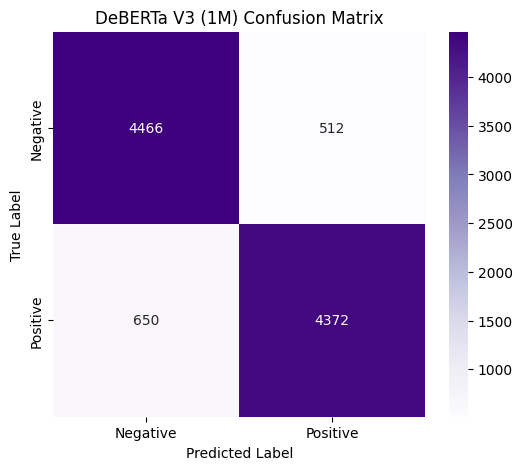


🔍 QUALITATIVE ERROR ANALYSIS
Total Errors: 1162

[False Positives] Predicted Positive, Actually Negative:
 🔴 survived day 1 of helping his sister move.
 🔴 very jealous of ANYONE going to Ibiza this week. Screw you all! But have a nice time
 🔴 It's official! I'm going to have an educational summer. Owh God. Bless me

[False Negatives] Predicted Negative, Actually Positive:
 🔵 Impatient one aren't u?The convention's for another 4.5 hours
 🔵 Oh...only 3 days for studying programming. That's not good...I wish I could be strong
 🔵 Damnit just talking about nakedness and cold water against my sunburnt skin is making me tingley


In [9]:
# ==========================================
# CELL 9: VISUALIZATION & ERROR ANALYSIS
# ==========================================
cm = confusion_matrix(test_df['sentiment'], preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('DeBERTa V3 (1M) Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()

print(f"\n🔍 QUALITATIVE ERROR ANALYSIS")
test_df['pred'] = preds
errors = test_df[test_df['sentiment'] != test_df['pred']]

print(f"Total Errors: {len(errors)}")
print("\n[False Positives] Predicted Positive, Actually Negative:")
for txt in errors[errors['pred'] == 1]['text'].head(3):
    print(f" 🔴 {txt}")

print("\n[False Negatives] Predicted Negative, Actually Positive:")
for txt in errors[errors['pred'] == 0]['text'].head(3):
    print(f" 🔵 {txt}")

# ==========================================
# CELL 10: DEPLOYMENT DASHBOARD
# ==========================================
# To run the interactive dashboard, execute the following command in your terminal:
# `python app.py`
#
# This will launch a local Gradio web interface where you can test the model with custom inputs.
